In [1]:
import gdown
import zipfile

## Caricamento ed estrazione del Dataset

In [2]:
!gdown 1Z29s38bbVmxLrFv4ni-0eeLd94WUatzo

Downloading...
From (original): https://drive.google.com/uc?id=1Z29s38bbVmxLrFv4ni-0eeLd94WUatzo
From (redirected): https://drive.google.com/uc?id=1Z29s38bbVmxLrFv4ni-0eeLd94WUatzo&confirm=t&uuid=c1e5a706-16ae-4e03-96f8-d31a56472ebf
To: /content/Impressionism Dataset Smaller Version.zip
100% 1.05G/1.05G [00:21<00:00, 48.6MB/s]


In [3]:
zip = zipfile.ZipFile("Impressionism Dataset Smaller Version.zip")
zip.extractall()
zip.close()

In [37]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
import os
import random
import matplotlib.image as mpimg
import math
import numpy as np
import seaborn as sns

## Gestione ed esplorazione del Dataset

In [5]:
training_path = "./Impressionism Dataset Smaller Version/Training"
test_path =  "./Impressionism Dataset Smaller Version/Test"
classes = os.listdir(training_path)
classes

['Cezanne', 'VanGogh', 'Monet', 'Matisse']

In [6]:
len(classes)

4

Analizzo il numero di immagini per autore nei dati di addestramento

In [7]:
occurrences_per_class = []
class_paths = []
for one_class in classes:

  path = os.path.join(training_path,one_class)
  class_paths.append(path)
  occurrences_per_class.append(len(os.listdir(path)))

occurrences_per_class

[399, 399, 399, 399]

Visualizzazione di alcune immagini, estrandone a caso una per autore

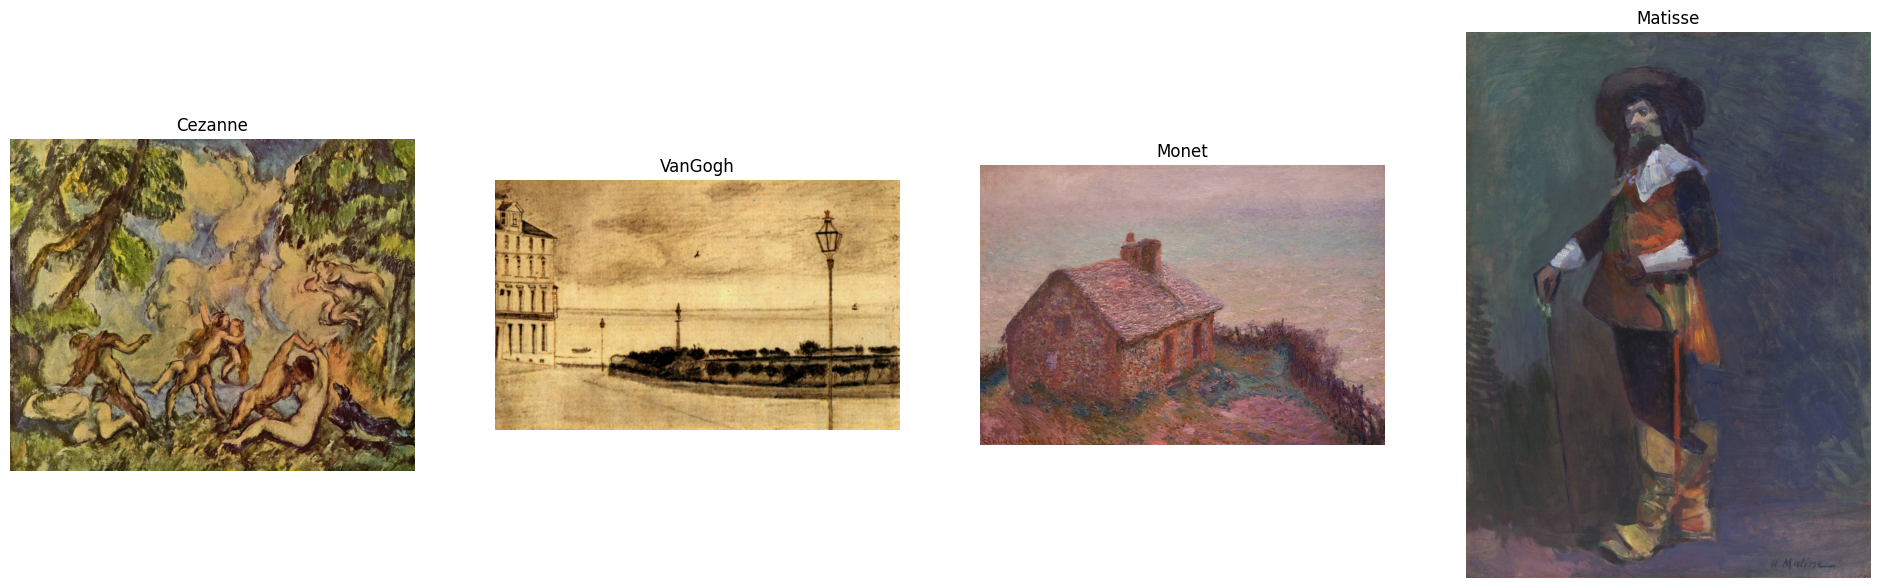

In [9]:
sample_images = []
for class_path in class_paths:
  images = os.listdir(class_path)
  sample_image = random.sample(images, 1)
  path__sample_image = os.path.join(class_path,sample_image[0])
  sample_images.append(path__sample_image)

shape_list = []
plt.figure(figsize=(24, 14))
for i,image in enumerate(sample_images):
        author = image.split("/")[-2]
        img = mpimg.imread(image)
        shape_list.append(img.shape)
        plt.subplot(1,4,i+1)
        plt.imshow(img)
        plt.title(author)
        plt.axis('off')
plt.show()

Problema: le immagini hanno dimensione diversa tra loro

In [10]:
shape_list

[(2079, 2536, 3), (787, 1271, 3), (1106, 1600, 3), (1366, 1012, 3)]

In [11]:
img[:,:,0]

array([[103, 104, 101, ...,  99,  98,  97],
       [ 97,  98,  95, ...,  89,  89,  89],
       [ 98,  99,  96, ...,  86,  90,  93],
       ...,
       [109, 106, 103, ..., 114, 113, 112],
       [103, 102, 100, ..., 113, 113, 114],
       [ 98,  98,  98, ..., 112, 114, 117]], dtype=uint8)

In [12]:
img.shape

(1366, 1012, 3)

In [13]:
img[:,:,0].shape

(1366, 1012)

Analizzo il numero di immagini per autore nei dati di test

In [14]:
occurrences_per_class = []
for one_class in classes:

  class_path = os.path.join(test_path,one_class)
  occurrences_per_class.append(len(os.listdir(class_path)))

occurrences_per_class

[99, 99, 99, 99]

In [24]:
input_shape = (256,256,3)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.25
)


test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size= (input_shape[0],input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)


validation_generator = train_datagen.flow_from_directory(
    training_path,
    target_size= (input_shape[0],input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size= (input_shape[0],input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1200 images belonging to 4 classes.
Found 396 images belonging to 4 classes.
Found 396 images belonging to 4 classes.


## Creazione della rete neurale

In [15]:
def conv_output_dimension(input_dimension,dimension_filter,number_filters,padding = 0, stride = 1):

  output_dim = int(((input_dimension + 2*padding - dimension_filter)/stride) + 1)

  output_shape = (output_dim,output_dim,number_filters)
  return output_shape


conv_output_dimension(256,3,32)



(254, 254, 32)

Analogamente

In [16]:
def maxpool_output_dimension(input_dimension,dimension_filter,padding = 0, stride = 2):

      output_dim = int(((input_dimension - dimension_filter) / stride) + 1)

      output_shape = (output_dim,output_dim)
      return output_shape

maxpool_output_dimension(254,2)

(127, 127)

In [17]:
x = np.random.rand(4, 256, 256, 3)
y = layers.Conv2D(32, 3, activation='relu')(x)
y = layers.MaxPooling2D((2,2))(y)
y_flat = layers.Flatten()(y)
print(y_flat.shape)

(4, 516128)


In [18]:
dense_number =  y.shape[1] * y.shape[1] * y.shape[-1]
dense_number

516128

In [25]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape = input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape = input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(classes), activation='softmax'))

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [28]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_generator,
    steps_per_epoch=1200//32,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=396//32,
    callbacks= early_stopping
)

Epoch 1/30
37/37 [==============================] - 65s 2s/step - loss: 1.9563 - accuracy: 0.2860 - val_loss: 1.3266 - val_accuracy: 0.3516
Epoch 2/30
37/37 [==============================] - 53s 1s/step - loss: 1.2764 - accuracy: 0.4195 - val_loss: 1.3631 - val_accuracy: 0.3411
Epoch 3/30
37/37 [==============================] - 52s 1s/step - loss: 1.2832 - accuracy: 0.4050 - val_loss: 1.2749 - val_accuracy: 0.3932
Epoch 4/30
37/37 [==============================] - 60s 2s/step - loss: 1.2410 - accuracy: 0.4486 - val_loss: 1.2872 - val_accuracy: 0.4688
Epoch 5/30
37/37 [==============================] - 50s 1s/step - loss: 1.2127 - accuracy: 0.4923 - val_loss: 1.2808 - val_accuracy: 0.4427
Epoch 6/30
37/37 [==============================] - 59s 2s/step - loss: 1.1895 - accuracy: 0.5094 - val_loss: 1.1617 - val_accuracy: 0.5365
Epoch 7/30
37/37 [==============================] - 50s 1s/step - loss: 1.1599 - accuracy: 0.5214 - val_loss: 1.2145 - val_accuracy: 0.5026
Epoch 8/30
37/37 [==

# Visualizzazione andamento addestramento

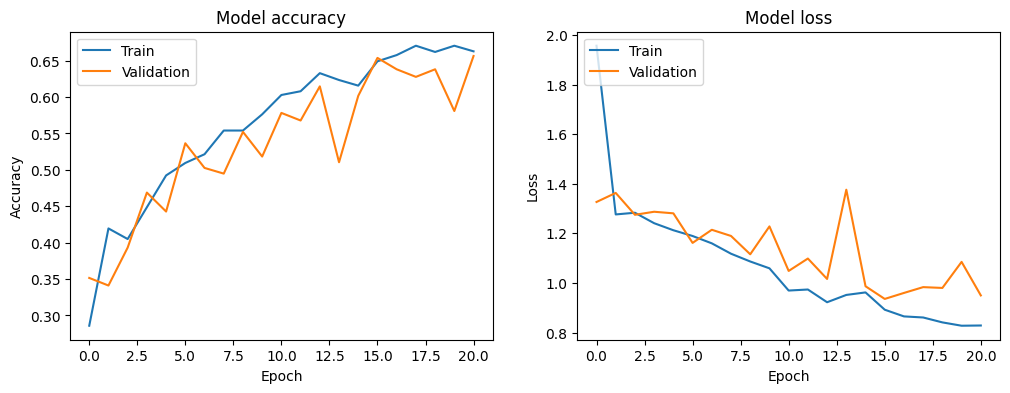

In [29]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
model.save_weights('./weights.h5')

# Valutazione performance

In [30]:
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32")


13/13 [==============================] - 8s 622ms/step


In [31]:
pred = np.argmax(predicted_classes, axis = 1)
pred

array([0, 0, 0, 2, 0, 0, 0, 3, 0, 2, 1, 2, 1, 0, 0, 0, 2, 3, 0, 0, 2, 0,
       0, 0, 3, 0, 0, 2, 3, 0, 3, 2, 2, 0, 3, 3, 0, 3, 2, 2, 0, 2, 2, 0,
       2, 2, 0, 0, 2, 3, 0, 0, 0, 2, 0, 0, 3, 3, 3, 3, 1, 3, 2, 0, 2, 3,
       2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 3, 2, 0, 0, 3, 0,
       3, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 2, 0, 0, 3, 3, 1, 1, 1, 3,
       3, 3, 1, 3, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 3, 2, 3, 1,
       1, 2, 1, 0, 0, 1, 3, 1, 3, 1, 1, 1, 2, 1, 1, 1, 2, 0, 1, 0, 0, 0,
       1, 1, 2, 0, 0, 0, 1, 1, 2, 1, 1, 1, 0, 1, 1, 0, 0, 2, 2, 1, 0, 1,
       0, 0, 0, 0, 2, 1, 1, 0, 3, 1, 3, 1, 3, 0, 0, 0, 0, 2, 0, 1, 0, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 0, 0, 2, 2, 2, 3, 2, 2,
       0, 0, 2, 2, 2, 3, 0, 0, 0, 1, 0, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2,
       3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 3, 3, 0, 3, 0, 2, 2, 2, 3, 2, 2, 3,
       3, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 0, 2, 2, 3, 2, 0, 2, 2, 3, 3, 3, 3,

In [34]:
true_labels = test_generator.labels
#true_labels = to_categorical(true_labels)
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,

In [35]:
accuracy = accuracy_score(true_labels, pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5959595959595959


<Axes: >

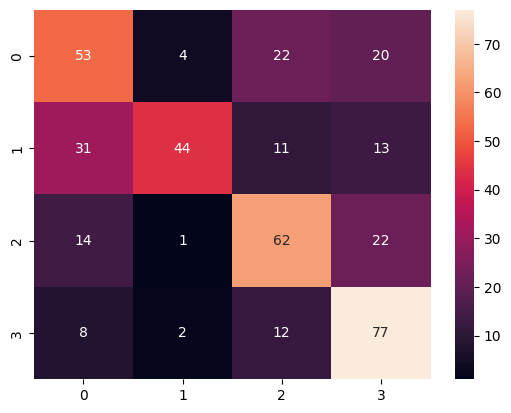

In [38]:
conf_matrix = confusion_matrix(true_labels, pred)
sns.heatmap(conf_matrix, annot=True)

In [39]:
class_report = classification_report(true_labels, pred)
print(f"Classification Report:\n{class_report}")

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.54      0.52        99
           1       0.86      0.44      0.59        99
           2       0.58      0.63      0.60        99
           3       0.58      0.78      0.67        99

    accuracy                           0.60       396
   macro avg       0.63      0.60      0.59       396
weighted avg       0.63      0.60      0.59       396



# Transfer Learning

In [51]:
from tensorflow.keras.applications import ResNet50


resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


for layer in resnet.layers:
    layer.trainable = False



model_resnet = models.Sequential()
model_resnet.add(resnet)
model_resnet.add(layers.Flatten())
model_resnet.add(layers.Dense(1028, activation='relu'))
model_resnet.add(layers.Dropout(0.3))
model_resnet.add(layers.Dense(len(classes), activation='softmax'))

In [52]:
model_resnet.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_6 (Flatten)         (None, 131072)            0         
                                                                 
 dense_10 (Dense)            (None, 1028)              134743044 
                                                                 
 dropout_5 (Dropout)         (None, 1028)              0         
                                                                 
 dense_11 (Dense)            (None, 4)                 4116      
                                                                 
Total params: 158334872 (604.00 MB)
Trainable params: 134747160 (514.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [53]:
model_resnet.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [54]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history_resnet = model_resnet.fit(
    train_generator,
    steps_per_epoch=1200//32,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=396//32,
    callbacks= early_stopping
)

Epoch 1/30
37/37 [==============================] - 67s 2s/step - loss: 26.3740 - accuracy: 0.2825 - val_loss: 6.0917 - val_accuracy: 0.3880
Epoch 2/30
37/37 [==============================] - 59s 2s/step - loss: 3.3469 - accuracy: 0.3211 - val_loss: 1.2639 - val_accuracy: 0.4167
Epoch 3/30
37/37 [==============================] - 60s 2s/step - loss: 1.3201 - accuracy: 0.3613 - val_loss: 1.9965 - val_accuracy: 0.2526
Epoch 4/30
37/37 [==============================] - 53s 1s/step - loss: 1.3849 - accuracy: 0.3459 - val_loss: 1.3082 - val_accuracy: 0.3281
Epoch 5/30
37/37 [==============================] - 60s 2s/step - loss: 1.3074 - accuracy: 0.3596 - val_loss: 1.2349 - val_accuracy: 0.4271
Epoch 6/30
37/37 [==============================] - 59s 2s/step - loss: 1.3133 - accuracy: 0.3425 - val_loss: 1.2045 - val_accuracy: 0.4297
Epoch 7/30
37/37 [==============================] - 55s 1s/step - loss: 1.2836 - accuracy: 0.3733 - val_loss: 1.2491 - val_accuracy: 0.4323
Epoch 8/30
37/37 [=